## Gaussian Information Bottleneck Tutorial
Simple implementation by Michele Nardin (https://github.com/michnard)

### The problem
Assume that $(X,Y)$ are jointly normal $\mathcal{N}(0,C)$. Denote with $C_x, C_y$ the covariance of the two variables $X,Y$ separately, and $C_{xy}$ the covariance between $X$ and $Y$.

Following Gal Chechik,Amir Globerson, Naftali Tishby, and Yair Weiss (JMLR 2005), we want to find the linear projection $T = AX$ that compresses $X$ while preserving information about $Y$. The tradeoff between compression and preservation is given by a parameter $\beta>0$, and can be formalized by asking we minimize the following loss function:
$$\mathcal{L}(\beta) = I(T;X) - \beta I(T;Y)$$

#### Useful preliminaries
We need to know a couple of things about multivariate gaussian distributions:

1) A linear projection of a gaussian variable is still gaussian, so $T \sim \mathcal{N}(0, A C_x A^T)$.

2) The variable $X|Y$ is also gaussian, and its covariance is $C_{x|y} = C_x - C_{xy}C_y^{-1}C_{xy}^T$

3) The entropy of a multivariate gaussian goes like the log determinant of its covariance: $H(X) \propto \ln |C_x|$

In [1]:
# classical imports
import numpy as np
from scipy import stats
from scipy.linalg import eig
import matplotlib.pyplot as plt

In [2]:
# random covariance matrix
np.random.seed(2)
Nx = 20 # dimensionality of X (var to be compressed)
Ny = 10 # dimensionality of Y (relevance variable - to be preserved)
# random covariance matrix of dimension Nx + Ny
C = np.random.randn(Nx + Ny, Nx + Ny)
C = C @ C.T # make it positive definite
np.all(np.linalg.eigvals(C) > 0)

True

#### Step 1: left eigenvectors of $D = C_{x|y}C_{x}^{-1}$

In the paper, the authors describe the procedure to get to the optimal $A$ for a given value of $\beta$.

It's going to be a weighted combination of the left eigenvectors of the matrix $D = C_{x|y}C_{x}^-1$. Let's make a script to compute them:

In [3]:
# return left eigenvectors of C_x_given_y Cx^-1
def left_eigenvectors(C, Nx):
    Cx = C[:Nx, :Nx] # upper corner
    Cxy = C[:Nx, Nx:] # X,Y block
    Cyx = Cxy.T
    Cy = C[Nx:, Nx:] # lower corner
    Cx_inv = np.linalg.inv(Cx)
    Cy_inv = np.linalg.inv(Cy)
    C_x_given_y = Cx - Cxy @ Cy_inv @ Cyx
    # use scipy.linalg.eig to get left eigenvectors
    eigvals, eigvecs = eig(C_x_given_y@Cx_inv,left=True,right=False)
    # return sorted by eigenvalue
    il = np.argsort(np.real(eigvals))
    return eigvals[il], eigvecs[:,il]

In [4]:
eigvals, eigvecs = left_eigenvectors(C, Nx)
np.real(eigvals)

array([0.00290682, 0.01609489, 0.05695574, 0.10801108, 0.1982006 ,
       0.30251247, 0.40893252, 0.49389264, 0.71864696, 0.85641367,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

#### Step 2: critical $\beta$ values

The projection matrix $A$ is going to be zero everywhere for $\beta \leq 1$.
From there onwards, A is built row by row, and a nonzero row is added whenever $\beta > \hat\beta_i$, where $\hat \beta_i$ are called critical values and measured as $\hat \beta_i = \frac{1}{1 - \lambda_i}$, where $\lambda_i$ is the i-th left eigenvalue of $D$.

In [5]:
# compute first Ny critical values given eigenvalues
def beta_crit(eigvals, Ny): 
    return 1/(1-np.real(eigvals)[:Ny])

In [6]:
beta_critical = beta_crit(eigvals, Ny)
beta_critical

array([1.0029153 , 1.01635817, 1.06039561, 1.12109016, 1.24719474,
       1.43371739, 1.69185421, 1.97586537, 3.55425338, 6.96445142])

#### Step 3: weights associated with eigenvectors

There are some other variables needed for the projection: $$r_i = v_i^T C_x v_i$$ and $$\alpha_i = \sqrt{\frac{\beta(1 - \lambda_i) - 1}{\lambda_i r_i}}$$ if $\beta > \hat \beta_i$, and zero otherwise, for $i=1,...,N_y$

In [7]:
# compute ris values given eigenvects and Cx
def ris(eigvecs, Cx, Ny):
    ris = np.zeros(Ny)
    for i in range(Ny):
        ris[i] = eigvecs[:,i]@Cx@eigvecs[:,i].T
    return ris
# compute alpha coefficients, given beta, eigvals and ris
def alpha_coeff(beta,beta_critical,ris, eigvals,Ny):
    alpha = np.zeros(Ny)
    for i in range(Ny):
        if beta < beta_critical[i]:
            alpha[i] = 0
        else:
            alpha[i] = np.sqrt((beta * (1 - np.real(eigvals[i])) - 1) / (np.real(eigvals[i]) * ris[i]))
    return alpha

In [8]:
rs = ris(eigvecs, C[:Nx,:Nx], Ny)
rs

array([14.2416381 ,  7.31868195, 13.4320671 , 15.94026884,  7.85118798,
       18.86399608, 15.28947142,  8.85715297, 17.85667647, 16.00540295])

#### Step 4: projection matrix

Now we're finally ready to compose our matrix: given $\beta$, we get a vector of $\alpha$ values, and $A$ is going to be the $N_y \times N_x$ matrix built by the first $N_y$ left eigenvectors of $D$, each weighted by its $\alpha_i$: $$[\alpha_1 v_1, \alpha_2 v_2, \dots, \alpha_{Ny}v_{Ny}]$$

In [9]:
# projection matrix, given eigenvs and alpha
def projection_matrix(alpha,eigvecs, Ny):
    return (np.real(eigvecs[:,:Ny]) @ np.diag(alpha)).T

In [10]:
beta = 5
alp = alpha_coeff(beta, beta_critical, rs, eigvals, Ny)
A=projection_matrix(alp, eigvecs, Ny)

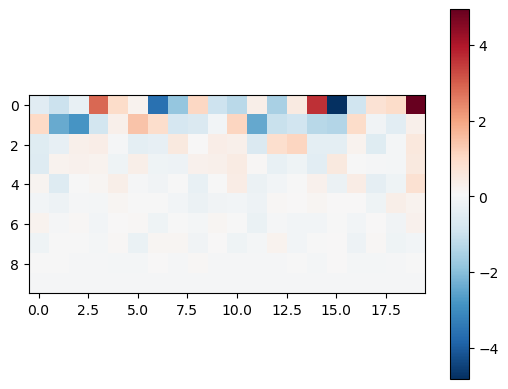

In [11]:
plt.imshow(A, cmap='RdBu_r')
plt.colorbar()

## visualize difference in projection matrix for increasing $\beta$

Text(0.5, 1.05, 'Projection matrix A for different beta values')

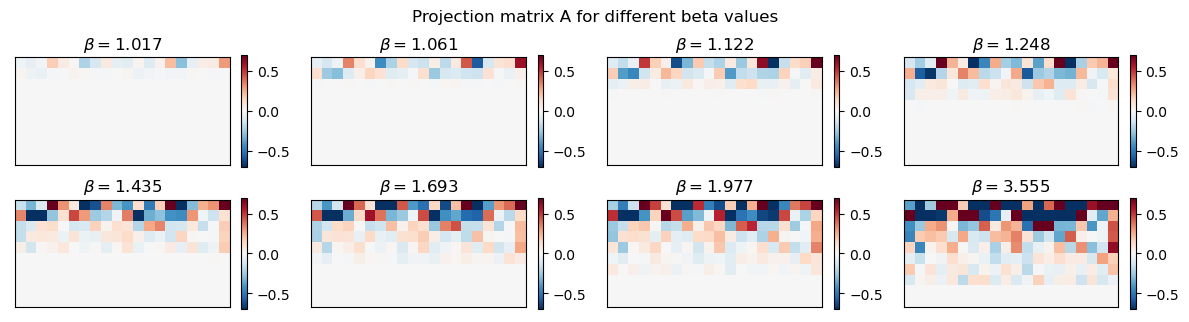

In [14]:
# see the difference for different beta values just after critical values
plt.figure(figsize=(12,3))
for ib,beta in enumerate(beta_critical[1:9]+0.001):
    plt.subplot(2,4,ib+1)
    alp = alpha_coeff(beta, beta_critical, rs, eigvals, Ny)
    A=projection_matrix(alp, eigvecs, Ny)
    plt.imshow(A,cmap='RdBu_r',vmin=-0.7,vmax=0.7)
    plt.xticks([])
    plt.yticks([])
    plt.title(r'$\beta = $'+str(np.round(beta,3)))
    # make colorbar smaller
    plt.colorbar(fraction=0.035)
plt.tight_layout()
plt.suptitle('Projection matrix A for different beta values',y=1.05)

## Example: recover the original Y, given AX, for different beta values

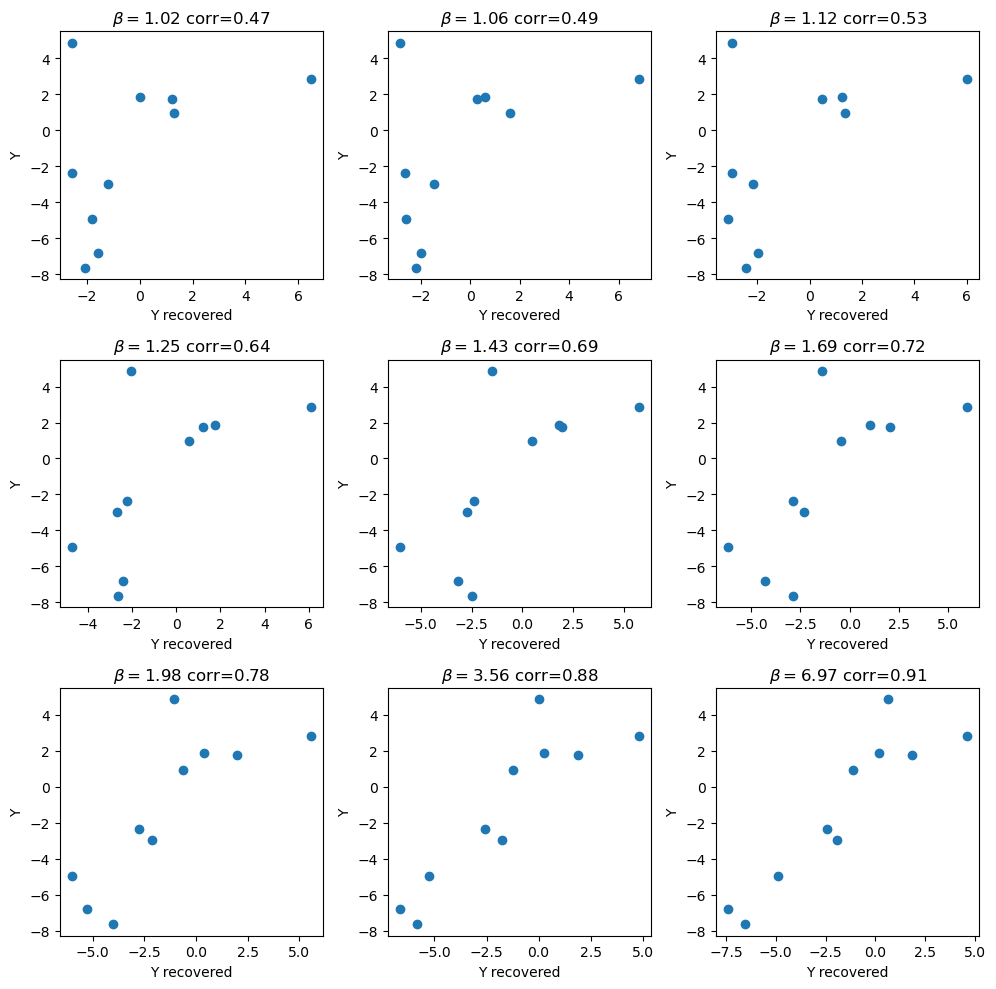

In [25]:
# draw one sample (X,Y) from the gaussian with mean 0 and covariance C
np.random.seed(9)
sample = stats.multivariate_normal.rvs(mean=np.zeros(len(C)), cov=C)
X = sample[:Nx]
Y = sample[Nx:]
# subblocks of C
Cx = C[:Nx, :Nx]
Cxy = C[:Nx, Nx:]
Cyx = Cxy.T
Cy = C[Nx:, Nx:]

plt.figure(figsize=(10,10))
for ib,beta in enumerate(beta_critical[1:]+0.001):
    plt.subplot(3,3,ib+1)
    alp = alpha_coeff(beta, beta_critical, rs, eigvals, Ny)
    # pass X it through the projection matrix
    A = projection_matrix(alp, eigvecs, Ny)
    b = A @ X
    # compare with the original signal
    # compute projection matrix
    pro = Cyx@A.T@np.linalg.inv(A@Cx@A.T + np.eye(Ny))
    # scatter orginal vs recovered
    plt.scatter(pro@b, Y)
    plt.ylabel('Y')
    plt.xlabel('Y recovered')
    # title: beta and correlation
    plt.title(r'$\beta = $'+str(np.round(beta,2))+' corr='+str(np.round(np.corrcoef(pro@b,Y)[0,1],2)))
plt.tight_layout()